In [95]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import math

In [96]:
def load_dataset():
    train_dataset = h5py.File('../../dataset/CNN/dataset/train_signs.h5', "r")
    test_dataset = h5py.File('../../dataset/CNN/dataset/test_signs.h5', "r")
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    print(train_set_y_orig.shape)
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    print(test_set_y_orig.shape)
    train_set_y_orig = train_set_y_orig.reshape((1,-1))
    test_set_y_orig = test_set_y_orig.reshape((1,-1))
    
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    print(train_set_x_orig.shape)
    print(train_set_y_orig.shape)
    print(test_set_x_orig.shape)
    print(test_set_y_orig.shape)
    return train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes
    

In [97]:
def one_hot_encoding(y,c):
    return np.squeeze(np.eye(c)[y])


In [98]:
train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes = load_dataset()

(1080,)
(120,)
(1080, 64, 64, 3)
(1, 1080)
(120, 64, 64, 3)
(1, 120)


y=0


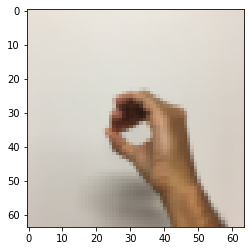

In [118]:
# plotting input data sample
index=0
plt.imshow(train_set_x_orig[index])
print("y="+str(np.squeeze(train_set_y_orig[:,index])))


y=2


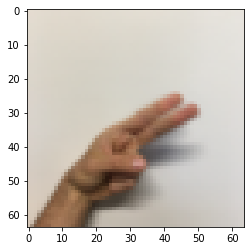

In [116]:
index=2
plt.imshow(train_set_x_orig[index])
print("y="+str(np.squeeze(train_set_y_orig[:,index])))

y=0


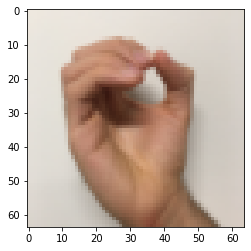

In [115]:
index=1
plt.imshow(train_set_x_orig[index])
print("y="+str(np.squeeze(train_set_y_orig[:,index])))


In [100]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
train_x = train_set_x_flatten/255
test_x  = test_set_x_flatten/255
train_y = one_hot_encoding(train_set_y_orig,6).T
test_y  = one_hot_encoding(test_set_y_orig,6).T
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(12288, 1080)
(6, 1080)
(12288, 120)
(6, 120)


In [101]:
# the model used will be LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
def create_placeholder(n_x,n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X,Y

In [102]:
X, Y = create_placeholder(12288, 6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(6, ?), dtype=float32)


In [103]:
def init_params():
    
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [104]:
def fwd_prop(X,parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # LF->RELU->LF-> RELU-> LF
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)              
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)               
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

In [105]:
def compute_cost(Z3,Y):    
    # computed output and actual output are transposed because function require m x n format. (m - sample size)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [106]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholder(12288, 6)
    params = init_params()
    Z3 = fwd_prop(X, params)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))


cost = Tensor("Mean:0", shape=(), dtype=float32)


In [107]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [112]:
def model(train_x,train_y,test_x,test_y,learning_rate=0.0001,number_of_epochs=1500,mini_batch_size=64):
    ops.reset_default_graph()
    seed=4
    m=train_x.shape[1]
    no_of_mini_batches = int(m/mini_batch_size)
    tf.set_random_seed(1)
    size_train_x = train_x.shape[0]
    size_train_y = train_y.shape[0]
    cost_array = []
    X,Y = create_placeholder(size_train_x, size_train_y)
    params = init_params()
    Z3 = fwd_prop(X, params)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # Initialize all the variables
    init = tf.global_variables_initializer()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(number_of_epochs):
            epoch_cost = 0
            seed+=1
            minibatches = random_mini_batches(train_x, train_y, mini_batch_size, seed)
            for minibatch in minibatches:
                (mini_batch_x,mini_batch_y) = minibatch
                _ , epoch_cost_temp = sess.run([optimizer, cost], feed_dict={X: mini_batch_x, Y: mini_batch_y})
                epoch_cost += epoch_cost_temp/no_of_mini_batches
            
            if epoch%5==0:
                cost_array.append(epoch_cost)
            if epoch%100==0:
                print("cost after epoch %i = %f",(epoch,epoch_cost))
        plt.plot(np.squeeze(cost_array))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        params= sess.run(params)
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Training accuracy:%f",(accuracy.eval({X:train_x,Y:train_y})))
        print("Test accuracy:%f",(accuracy.eval({X:test_x,Y:test_y})))
    return params
    

cost after epoch %i = %f (0, 1.9028721526265144)
cost after epoch %i = %f (100, 1.2415382117033005)
cost after epoch %i = %f (200, 0.9107170663774014)
cost after epoch %i = %f (300, 0.6300671994686127)
cost after epoch %i = %f (400, 0.4759795740246773)
cost after epoch %i = %f (500, 0.3593645431101322)
cost after epoch %i = %f (600, 0.27573380060493946)
cost after epoch %i = %f (700, 0.21875666175037622)
cost after epoch %i = %f (800, 0.17395611759275198)
cost after epoch %i = %f (900, 0.13595589250326157)
cost after epoch %i = %f (1000, 0.1067370215896517)
cost after epoch %i = %f (1100, 0.08955418597906828)
cost after epoch %i = %f (1200, 0.07517885114066303)
cost after epoch %i = %f (1300, 0.053846110007725656)
cost after epoch %i = %f (1400, 0.04505418136250228)


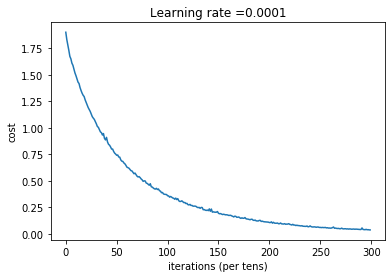

Training accuracy:%f 0.98888886
Test accuracy:%f 0.8666667


In [113]:
params = model(train_x,train_y,test_x,test_y,.0001)

y=0


TypeError: Input 'b' of 'MatMul' Op has type float64 that does not match type float32 of argument 'a'.

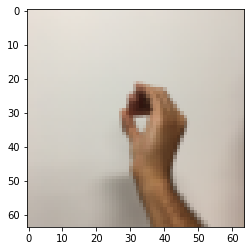

In [119]:
index=1
plt.imshow(test_set_x_orig[index])
print("y="+str(np.squeeze(test_set_y_orig[:,index])))
Z3 = fwd_prop(test_x[:,index],params)
p = np.argmax(z3)